In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import mlflow
import dagshub

import dagshub
dagshub.init(repo_owner='VEDA-2402', repo_name='ML_pipeline', mlflow=True)

import dagshub
dagshub.init(repo_owner='VEDA-2402', repo_name='ML_pipeline', mlflow=True)

import mlflow
mlflow.end_run()
with mlflow.start_run():
  mlflow.log_param('parameter name', 'value')
  mlflow.log_metric('metric name', 1)
  
mlflow.set_tracking_uri("https://dagshub.com/VEDA-2402/ML_pipeline.mlflow")

mlflow.set_experiment("store_sales_forecasting")


Accessing as VEDA-2402

Initialized MLflow to track repo "VEDA-2402/ML_pipeline"

Repository VEDA-2402/ML_pipeline initialized!

Initialized MLflow to track repo "VEDA-2402/ML_pipeline"

Repository VEDA-2402/ML_pipeline initialized!

🏃 View run thundering-bee-831 at: https://dagshub.com/VEDA-2402/ML_pipeline.mlflow/#/experiments/0/runs/59fdfea6bc754347b84c861537a93a2b
🧪 View experiment at: https://dagshub.com/VEDA-2402/ML_pipeline.mlflow/#/experiments/0


<Experiment: artifact_location='mlflow-artifacts:/2e30c3bae17744acb03567c38af3312b', creation_time=1763978633012, experiment_id='1', last_update_time=1763978633012, lifecycle_stage='active', name='store_sales_forecasting', tags={}>

In [2]:
# reading and merging 

df = pd.read_csv("train.csv", low_memory= False)
store = pd.read_csv("store.csv")

df = df.merge(store, on="Store", how="left")

In [3]:
# -------------------
# Basic Cleanup
# -------------------

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Drop closed days (sales = 0)
df = df[df["Open"] == 1]

# Convert StateHoliday
df['StateHoliday'] = df['StateHoliday'].replace({'0': 0, 'a': 1, 'b': 2, 'c': 3}).astype(int)

# -------------------
# Feature Engineering
# -------------------
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
df['IsWeekend'] = df['DayOfWeek'].isin([6,7]).astype(int)

# -------------------
# Handle Missing Store Data
# -------------------

# CompetitionDistance NaN → very large distance
df['CompetitionDistance'] = df['CompetitionDistance'].fillna(df['CompetitionDistance'].median())

# Promo2 and related columns
df['Promo2'] = df['Promo2'].fillna(0).astype(int)

df['Promo2SinceWeek'] = df['Promo2SinceWeek'].fillna(0).astype(int)
df['Promo2SinceYear'] = df['Promo2SinceYear'].fillna(0).astype(int)

# Competition open dates
df['CompetitionOpenSinceMonth'] = df['CompetitionOpenSinceMonth'].fillna(0).astype(int)
df['CompetitionOpenSinceYear'] = df['CompetitionOpenSinceYear'].fillna(0).astype(int)

# -------------------
# Time-based Lag Features (store-wise)
# -------------------
df = df.sort_values(['Store', 'Date'])

df['Sales_lag1'] = df.groupby('Store')['Sales'].shift(1)
df['Sales_lag7'] = df.groupby('Store')['Sales'].shift(7)
df['Sales_lag14'] = df.groupby('Store')['Sales'].shift(14)

df['Sales_roll7'] = df.groupby('Store')['Sales'].shift(1).rolling(7).mean()
df['Sales_roll30'] = df.groupby('Store')['Sales'].shift(1).rolling(30).mean()

# Remove rows that became NaN due to lag features
df = df.dropna()

# -------------------
# Target Transformation
# -------------------
df['Sales'] = np.log1p(df['Sales'])

# -------------------
# Final Train Data
# -------------------
X = df.drop(['Sales', 'Date'], axis=1)
y = df['Sales']

print("Preprocessing complete. Shape:", X.shape)

Preprocessing complete. Shape: (403955, 26)


In [4]:
# dropping the object type data irrelevant to the model training 

cols_to_drop = ['Date', 'StoreType', 'Assortment', 'PromoInterval']

df = df.drop(columns=cols_to_drop, errors='ignore')
print ("dropped")

dropped


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 403955 entries, 975956 to 1114
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      403955 non-null  int64  
 1   DayOfWeek                  403955 non-null  int64  
 2   Sales                      403955 non-null  float64
 3   Customers                  403955 non-null  int64  
 4   Open                       403955 non-null  int64  
 5   Promo                      403955 non-null  int64  
 6   StateHoliday               403955 non-null  int64  
 7   SchoolHoliday              403955 non-null  int64  
 8   CompetitionDistance        403955 non-null  float64
 9   CompetitionOpenSinceMonth  403955 non-null  int64  
 10  CompetitionOpenSinceYear   403955 non-null  int64  
 11  Promo2                     403955 non-null  int64  
 12  Promo2SinceWeek            403955 non-null  int64  
 13  Promo2SinceYear            4039

In [6]:
df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,...,Year,Month,Day,WeekOfYear,IsWeekend,Sales_lag1,Sales_lag7,Sales_lag14,Sales_roll7,Sales_roll30
count,403955.000000,403955.000000,403955.000000,403955.000000,403955.0,403955.000000,403955.000000,403955.000000,403955.000000,403955.000000,...,403955.000000,403955.000000,403955.000000,403955.000000,403955.000000,403955.000000,403955.000000,403955.000000,403955.000000,403955.000000
mean,560.942365,3.515176,8.711453,683.218363,1.0,0.448184,0.000958,0.192972,4345.892488,4.570972,...,2013.862584,5.955723,15.895889,24.135280,0.173863,6581.047471,6570.337493,6573.664359,6576.432737,6565.304012
std,326.653474,1.719528,0.411870,323.022755,0.0,0.497308,0.038238,0.394632,5374.436532,4.321882,...,0.783212,3.231815,8.640773,13.989349,0.378992,2728.749563,2727.807882,2730.010929,2205.075407,2035.247861
min,2.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,20.000000,0.000000,...,2013.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1276.714286,1417.200000
25%,280.000000,2.000000,8.452761,481.000000,1.0,0.000000,0.000000,0.000000,570.000000,0.000000,...,2013.000000,3.000000,8.000000,12.000000,0.000000,4687.000000,4677.000000,4678.000000,5010.000000,5098.933333
50%,555.000000,3.000000,8.715716,615.000000,1.0,0.000000,0.000000,0.000000,2230.000000,4.000000,...,2014.000000,6.000000,16.000000,23.000000,0.000000,6095.000000,6082.000000,6087.000000,6223.285714,6260.033333
75%,850.000000,5.000000,8.979543,802.000000,1.0,1.000000,0.000000,0.000000,5650.000000,9.000000,...,2014.000000,8.000000,23.000000,35.000000,0.000000,7935.000000,7922.000000,7929.000000,7738.928571,7673.183333
max,1115.000000,7.000000,10.634701,4582.000000,1.0,1.000000,3.000000,1.000000,27190.000000,12.000000,...,2015.000000,12.000000,31.000000,52.000000,1.000000,41551.000000,41551.000000,41551.000000,29967.142857,22213.366667


In [ ]:
# Ensure data is sorted by date (VERY important)
df = df.sort_values("Year")  # or "Date" if Date exists before dropping

# Define test size (example: last 6 weeks = ~42 days)
test_size = int(0.10 * len(df))   # last 10% of data as test

# Create train & test sets
train_df = df.iloc[:-test_size]
test_df = df.iloc[-test_size:]

# Split X and y
X_train = train_df.drop("Sales", axis=1)
y_train = train_df["Sales"]

X_test = test_df.drop("Sales", axis=1)
y_test = test_df["Sales"]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (363560, 23) Test shape: (40395, 23)


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib 


with mlflow.start_run(run_name="XGBoost_Model"):

    # ------------------------
    # Initialize Model
    # ------------------------
    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        reg_lambda=1.0,
        random_state=42,
        tree_method="hist"
    )

    # ------------------------
    # Train Model
    # ------------------------
    model.fit(X_train, y_train)
    joblib.dump(model, "xgb_model.pkl")
    print ("training done")


training done
🏃 View run XGBoost_Model at: https://dagshub.com/VEDA-2402/ML_pipeline.mlflow/#/experiments/1/runs/c235452283ad41679c382b1e3459a6c6
🧪 View experiment at: https://dagshub.com/VEDA-2402/ML_pipeline.mlflow/#/experiments/1


In [ ]:
# ---- Log model parameters ----
mlflow.log_param("n_estimators", 500)
mlflow.log_param("learning_rate", 0.05)
mlflow.log_param("max_depth", 8)
mlflow.log_param("subsample", 0.8)
mlflow.log_param("colsample_bytree", 0.8)
mlflow.log_param("reg_lambda", 1.0)
mlflow.log_param("tree_method", "hist")

# predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# errors
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

train_mae = mean_absolute_error(y_train, train_pred)
test_mae = mean_absolute_error(y_test, test_pred)

train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

# ---- Log metrics to MLflow ----
mlflow.log_metric("train_rmse", train_rmse)
mlflow.log_metric("test_rmse", test_rmse)
mlflow.log_metric("train_mae", train_mae)
mlflow.log_metric("test_mae", test_mae)
mlflow.log_metric("train_r2", train_r2)
mlflow.log_metric("test_r2", test_r2)

# ---- Save model locally using joblib ----
import joblib
joblib.dump(model, "xgb_model.pkl")

# ---- Log saved model to DAGsHub MLflow ----
mlflow.log_artifact("xgb_model.pkl")

print("XGBoost training + MLflow logging completed!")


XGBoost training + MLflow logging completed!


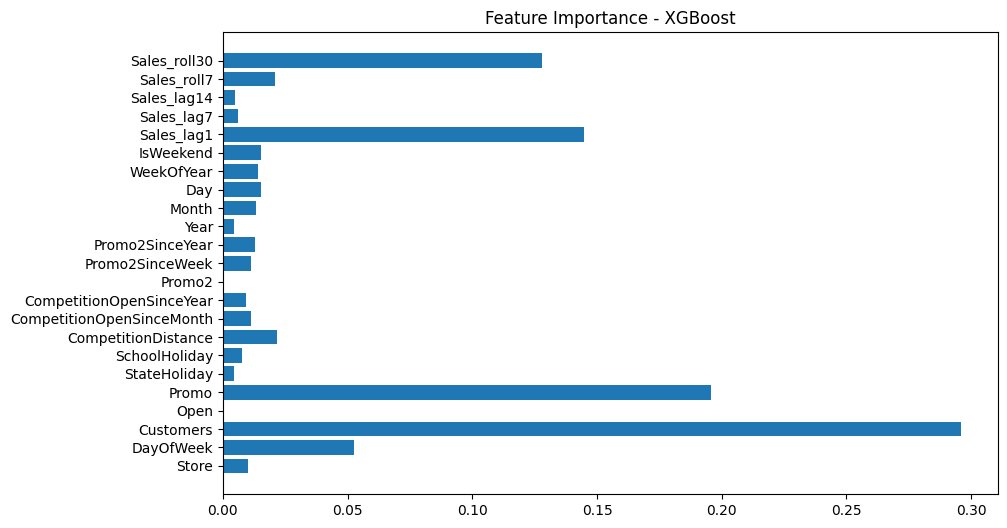

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, model.feature_importances_)
plt.title("Feature Importance - XGBoost")
plt.show()


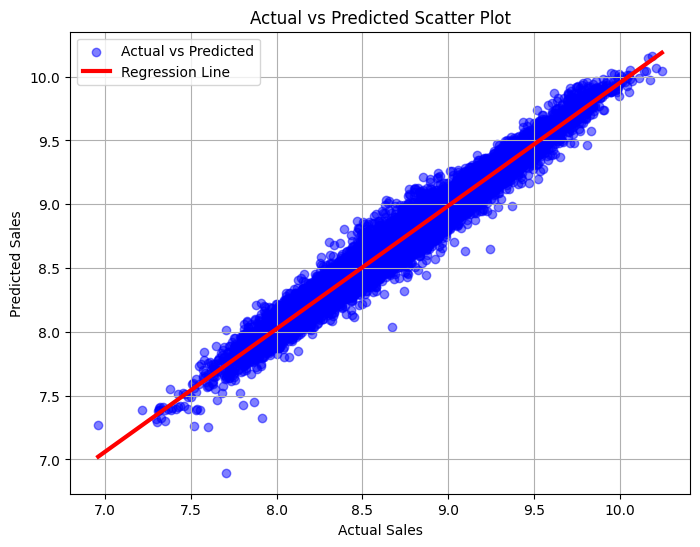

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot: actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_pred, alpha=0.5, color="blue", label="Actual vs Predicted")

# Regression line (different color)
m, b = np.polyfit(y_test, test_pred, 1)
line_x = np.linspace(min(y_test), max(y_test), 100)
line_y = m * line_x + b

plt.plot(
    line_x, 
    line_y, 
    color="red",     
    linewidth=3, 
    label="Regression Line"
)

plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Scatter Plot")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# LightGBM model training + MLflow logging

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import joblib

# ---------------------
# Train LightGBM Model
# ---------------------
mlflow.end_run()  # ensure no run is active

with mlflow.start_run(run_name="LightGBM_Model"):

    # ---- Initialize model ----
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=-1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    # ---- Log parameters ----
    mlflow.log_param("n_estimators", 1000)
    mlflow.log_param("learning_rate", 0.05)
    mlflow.log_param("max_depth", -1)
    mlflow.log_param("num_leaves", 31)
    mlflow.log_param("subsample", 0.8)
    mlflow.log_param("colsample_bytree", 0.8)

    # ---- Train model ----
    model.fit(X_train, y_train)

    # ---- Predictions ----
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # ---- Metrics ----
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

    train_mae = mean_absolute_error(y_train, train_pred)
    test_mae = mean_absolute_error(y_test, test_pred)

    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)

    # ---- Log metrics ----
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("test_r2", test_r2)

    # ---- Save model locally ----
    joblib.dump(model, "lgbm_model.pkl")

    # ---- Log model file ----
    mlflow.log_artifact("lgbm_model.pkl")

print("LightGBM: parameters, metrics, and model logged successfully!")
print("-----------------------------")
print("TRAIN RMSE:", train_rmse)
print("TEST RMSE:", test_rmse)
print("TRAIN MAE:", train_mae)
print("TEST MAE:", test_mae)
print("TRAIN R²:", train_r2)
print("TEST R²:", test_r2)


🏃 View run receptive-boar-371 at: https://dagshub.com/VEDA-2402/ML_pipeline.mlflow/#/experiments/1/runs/100d0848aa474fdb95b1c205aebd6f53
🧪 View experiment at: https://dagshub.com/VEDA-2402/ML_pipeline.mlflow/#/experiments/1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 363560, number of used features: 21
[LightGBM] [Info] Start training from score 8.705482
🏃 View run LightGBM_Model at: https://dagshub.com/VEDA-2402/ML_pipeline.mlflow/#/experiments/1/runs/ac0de06cdea141df8a15be216c43e747
🧪 View experiment at: https://dagshub.com/VEDA-2402/ML_pipeline.mlflow/#/experiments/1
LightGBM: parameters, metrics, and model logged successfully!
-----------------------------
TRAIN RMSE: 0.06672047683008005
TEST RMSE: 0.068970593303

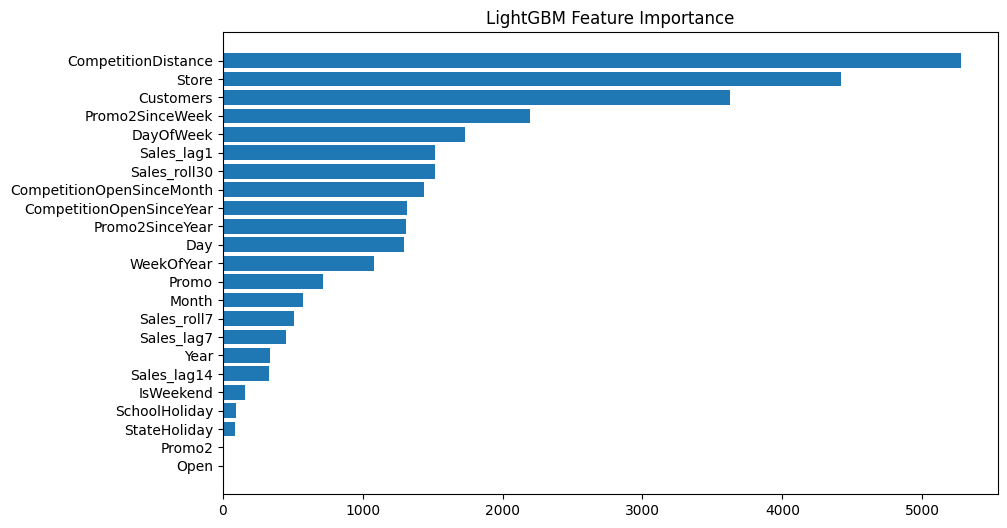

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
feat_imp = lgbm.feature_importances_
indices = np.argsort(feat_imp)[::-1]
names = X_train.columns[indices]

plt.barh(names, feat_imp[indices])
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.show()


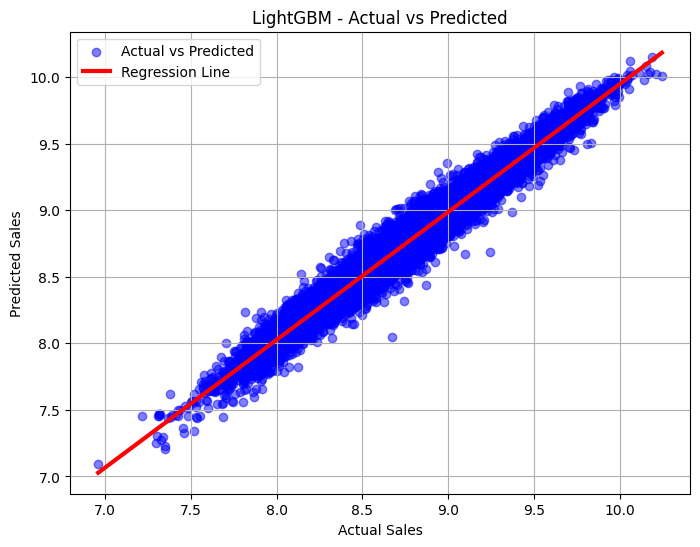

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_pred, alpha=0.5, color="blue", label="Actual vs Predicted")

m, b = np.polyfit(y_test, test_pred, 1)
line_x = np.linspace(min(y_test), max(y_test), 100)
line_y = m * line_x + b

plt.plot(line_x, line_y, color="red", linewidth=3, label="Regression Line")

plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("LightGBM - Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import numpy as np
import mlflow


with mlflow.start_run(run_name="CatBoost_Model"):

    # ------------------------
    # Initialize Model
    # ------------------------
    model = CatBoostRegressor(
        iterations=800,
        learning_rate=0.05,
        depth=8,
        loss_function="RMSE",
        random_state=42,
        l2_leaf_reg=3,
        bootstrap_type="MVS",   # More stable & often improves accuracy
        verbose=0               # Turn off training logs
    )

    # ------------------------
    # Train Model
    # ------------------------
    model.fit(X_train, y_train)
    joblib.dump(model, "catboost_model.pkl")
    print("CatBoost training done")

    # ---- Log model parameters ----
    mlflow.log_param("iterations", 800)
    mlflow.log_param("learning_rate", 0.05)
    mlflow.log_param("depth", 8)
    mlflow.log_param("l2_leaf_reg", 3)
    mlflow.log_param("bootstrap_type", "MVS")
    mlflow.log_param("loss_function", "RMSE")

    # ------------------------
    # Predictions
    # ------------------------
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # ------------------------
    # Metrics
    # ------------------------
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

    train_mae = mean_absolute_error(y_train, train_pred)
    test_mae = mean_absolute_error(y_test, test_pred)

    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)

    # ---- Log metrics ----
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("test_r2", test_r2)

    # ---- Log model ----
    mlflow.log_artifact("catboost_model.pkl")

print("CatBoost training + MLflow logging completed!")
